# Chunking
---

### Loading essential packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from matplotlib import pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Dense, Input, TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Data Pre-processing

In [2]:
with open("chunking.txt","r") as f:
  raw_corpus = f.readlines()

raw_corpus[0]

'Confidence NN B-NP\n'

In [3]:
corpus = []

for i in raw_corpus:
  corpus.append(i[:-1])

corpus[0]

'Confidence NN B-NP'

In [4]:
# x contains words and y contains pos-tags
x = []
y = []

x_sentence = []
y_sentence = []

# converting words into sentences
for i in corpus:
  s = i.split()
  if s:
    if s[0] != '.':
      x_sentence.append(s[0])
      y_sentence.append(s[2])
    else:
      x.append(x_sentence)
      y.append(y_sentence)
      x_sentence = []
      y_sentence = []

In [5]:
print(len(x), len(y))

8725 8725


In [6]:
vocab_size = len(set([word for sentence in x for word in sentence]))
num_tags   = len(set([word for sentence in y for word in sentence]))

print("Total Sentences:", len(x))
print("Vocabulary Size:", vocab_size)
print("Total Tags:", num_tags)

Total Sentences: 8725
Vocabulary Size: 19121
Total Tags: 22


In [7]:
print("sample X: ", x[0])
print("sample Y: ", y[0])
print(len(x[0]), len(y[0]))

sample X:  ['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits']
sample Y:  ['B-NP', 'B-PP', 'B-NP', 'I-NP', 'B-VP', 'I-VP', 'I-VP', 'I-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'B-SBAR', 'B-NP', 'I-NP', 'B-PP', 'B-NP', 'O', 'B-ADJP', 'B-PP', 'B-NP', 'B-NP', 'O', 'B-VP', 'I-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'I-NP', 'I-NP', 'B-NP', 'I-NP', 'I-NP']
36 36


In [8]:
# tokenizing x and y

# encode x
word_tokenizer = Tokenizer()                                              # instantiate tokeniser
word_tokenizer.fit_on_texts(x)                                          # fit tokeniser on data
x_encoded = word_tokenizer.texts_to_sequences(x)  

# encode y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y)
y_encoded = tag_tokenizer.texts_to_sequences(y)

In [9]:
# first encoded data point
print("** Raw data point **", "\n", "-"*100)
print('X: ', x[0])
print('Y: ', y[0])
print()
print("** Encoded data point **", "\n", "-"*100)
print('X: ', x_encoded[0])
print('Y: ', y_encoded[0])

** Raw data point ** 
 ----------------------------------------------------------------------------------------------------
X:  ['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits']
Y:  ['B-NP', 'B-PP', 'B-NP', 'I-NP', 'B-VP', 'I-VP', 'I-VP', 'I-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'B-SBAR', 'B-NP', 'I-NP', 'B-PP', 'B-NP', 'O', 'B-ADJP', 'B-PP', 'B-NP', 'B-NP', 'O', 'B-VP', 'I-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'I-NP', 'I-NP', 'B-NP', 'I-NP', 'I-NP']

** Encoded data point ** 
 ----------------------------------------------------------------------------------------------------
X:  [1535, 6, 2, 1636, 14, 1105, 183, 4, 206, 245, 1145, 4972, 70, 480, 565, 8, 460, 1, 251, 8, 1749, 2554, 1, 4170, 4, 597, 5, 1

In [10]:
print(len(x_encoded), len(y_encoded))

8725 8725


In [11]:
# calculating max length of words in longest sentence

max_len = 0

for i in x:
  if len(i) > max_len:
    max_len = len(i)

max_len

124

In [12]:
# manually padding

for i in range(len(x_encoded)):
  while(len(x_encoded[i])<max_len):
    x_encoded[i].append(0)

for i in range(len(y_encoded)):
  while(len(y_encoded[i])<max_len):
    y_encoded[i].append(0)

In [13]:
y_encoded = to_categorical(y_encoded)

## Splitting the Data

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y_encoded)

In [15]:
# converting into numpy arrays

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

## RNN Model

In [16]:
num_tags = y_train.shape[2]

In [17]:
# making of model
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size+1,100))
rnn_model.add(SimpleRNN(64, 
 return_sequences=True
))
rnn_model.add(TimeDistributed(Dense(num_tags, activation="softmax")))

# compile model
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

# summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1912200   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 64)          10560     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 23)          1495      
Total params: 1,924,255
Trainable params: 1,924,255
Non-trainable params: 0
_________________________________________________________________


In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6543, 124)
(6543, 124, 23)
(2182, 124)
(2182, 124, 23)


In [19]:
# training rnn model
rnn_training = rnn_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
52/52 [==============================] - 6s 94ms/step - loss: 1.7935 - acc: 0.6471 - val_loss: 0.5651 - val_acc: 0.8396
Epoch 2/10
52/52 [==============================] - 4s 71ms/step - loss: 0.5021 - acc: 0.8556 - val_loss: 0.3713 - val_acc: 0.9143
Epoch 3/10
52/52 [==============================] - 4s 83ms/step - loss: 0.3377 - acc: 0.9213 - val_loss: 0.2665 - val_acc: 0.9392
Epoch 4/10
52/52 [==============================] - 4s 71ms/step - loss: 0.2329 - acc: 0.9503 - val_loss: 0.1898 - val_acc: 0.9583
Epoch 5/10
52/52 [==============================] - 4s 69ms/step - loss: 0.1632 - acc: 0.9659 - val_loss: 0.1461 - val_acc: 0.9682
Epoch 6/10
52/52 [==============================] - 4s 72ms/step - loss: 0.1212 - acc: 0.9752 - val_loss: 0.1230 - val_acc: 0.9716
Epoch 7/10
52/52 [==============================] - 3s 65ms/step - loss: 0.0994 - acc: 0.9783 - val_loss: 0.1089 - val_acc: 0.9734
Epoch 8/10
52/52 [==============================] - 3s 66ms/step - loss: 0.0841 - a

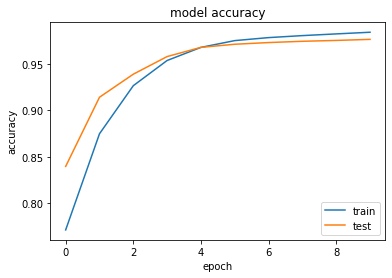

In [20]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [21]:
loss, accuracy = rnn_model.evaluate(x_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

69/69 [==============================] - 0s 6ms/step - loss: 0.0882 - acc: 0.9768
Loss: 0.08823484927415848,
Accuracy: 0.9768376350402832


In [26]:
rnn_model.save("rnn_model")

INFO:tensorflow:Assets written to: rnn_model/assets


## Bi-LSTM Model

In [22]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size+1, 100))
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(TimeDistributed(Dense(num_tags, activation="softmax")))
lstm_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1912200   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         84480     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 23)          2967      
Total params: 1,999,647
Trainable params: 1,999,647
Non-trainable params: 0
_________________________________________________________________


In [23]:
# training bi-lstm model
lstm_training = lstm_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
52/52 [==============================] - 13s 206ms/step - loss: 1.9105 - acc: 0.7443 - val_loss: 0.4407 - val_acc: 0.8698
Epoch 2/10
52/52 [==============================] - 11s 210ms/step - loss: 0.4119 - acc: 0.8712 - val_loss: 0.3699 - val_acc: 0.8703
Epoch 3/10
52/52 [==============================] - 13s 256ms/step - loss: 0.3566 - acc: 0.8755 - val_loss: 0.3441 - val_acc: 0.8910
Epoch 4/10
52/52 [==============================] - 11s 209ms/step - loss: 0.3381 - acc: 0.8940 - val_loss: 0.3115 - val_acc: 0.8981
Epoch 5/10
52/52 [==============================] - 14s 268ms/step - loss: 0.2929 - acc: 0.9034 - val_loss: 0.2392 - val_acc: 0.9345
Epoch 6/10
52/52 [==============================] - 16s 301ms/step - loss: 0.2112 - acc: 0.9465 - val_loss: 0.1532 - val_acc: 0.9623
Epoch 7/10
52/52 [==============================] - 16s 300ms/step - loss: 0.1306 - acc: 0.9695 - val_loss: 0.1124 - val_acc: 0.9717
Epoch 8/10
52/52 [==============================] - 18s 339ms/step - 

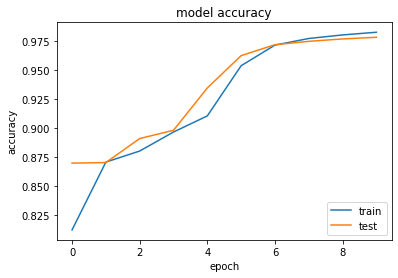

In [24]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [25]:
loss, accuracy = lstm_model.evaluate(x_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

69/69 [==============================] - 2s 23ms/step - loss: 0.0809 - acc: 0.9781
Loss: 0.08087819069623947,
Accuracy: 0.9781237840652466


In [27]:
lstm_model.save("lstm_model")

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets
